In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
from functools import partial
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

100%|██████████| 1/1 [00:13<00:00, 13.61s/it]

type <class 'dict'>


# prediction plots

In [3]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

acc 0.841 vs baseline 0.66


# look at different dsets

In [3]:
print("loading data")
dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak', 'clath_aux_dynamin'] # need to add dynamin
splits = ['train', 'test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized', 'y_consec_thresh']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, filter_short=False, normalize=False)

# df_full = pd.concat([dfs[(k, s)]
#                  for (k, s) in dfs
#                  if s == 'train'])[feat_names + meta]
# df_full = df_full.dropna()
ds = {(k, v): dfs[(k, v)]
      for (k, v) in sorted(dfs.keys(), key=lambda x: x[1] + x[0])
      #if not k == 'clath_aux+gak_a7d2_new'
     }

  0%|          | 0/6 [00:00<?, ?it/s]

loading data


100%|██████████| 6/6 [02:30<00:00, 25.08s/it]


**summarize dsets**

In [4]:
vals = {} # key is dataset, Partition
for k in sorted(ds, key=lambda kv: (kv[0], kv[1])):
    d = ds[k]
    d.short = d.lifetime <= 15
    # print(k, d.lifetime.min())
    y = d['y_consec_thresh']
    feats = ['Total clean tracks',
             'Difficult tracks', 'Difficult valid events', 
             'Short tracks', 'Short valid events',]
    vals[k] = [d.shape[0],
            (~d.short).sum(), y[~d.short].sum(),
            d.short.sum(), y[d.short].sum()
           ]
    vals[k] = [int(x) for x in vals[k]]
#     print(feats, vals)
df = pd.DataFrame.from_dict(vals).transpose().round(decimals=0)
df.columns = feats
df.index = df.index.set_names(['Dataset', 'Partition'])
print(df.to_latex(index=True, index_names=True))

\begin{tabular}{llrrrrr}
\toprule
          &       &  Total clean tracks &  Difficult tracks &  Difficult valid events &  Short tracks &  Short valid events \\
Dataset & Partition &                     &                   &                         &               &                     \\
\midrule
clath\_aux+gak & test &                1551 &               494 &                     264 &          1057 &                  96 \\
          & train &                5783 &              1750 &                    1054 &          4033 &                 464 \\
clath\_aux+gak\_a7d2 & test &                2448 &              1018 &                     439 &          1430 &                  73 \\
          & train &                7245 &              2979 &                    1523 &          4266 &                 212 \\
clath\_aux+gak\_a7d2\_new & test &               16893 &              1495 &                     978 &         15398 &                2157 \\
          & train &               497

**look at preds**

<ipython-input-85-eb83b6147e67>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, i + 1)


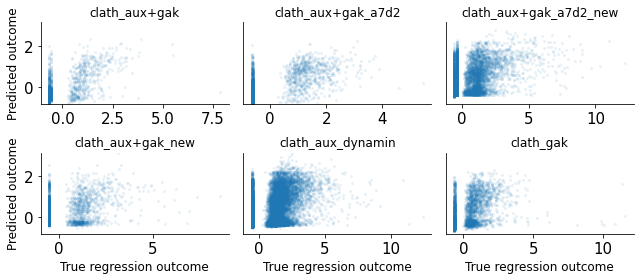

In [85]:
R = 2
C = len(ds) // 2 // R
plt.figure(figsize=(C*3, R*2))
i = 0
vmin = 0
vmax = 0
for k in sorted(ds):
    if k[1] == 'test':
        d = ds[k]
        preds = dnn.predict(d[feat_names[:1]])
        plt.subplot(R, C, i + 1)
        plt.title(k[0], fontsize=12)
        plt.plot(d['Y_sig_mean_normalized'], preds, '.', alpha=0.1, markeredgewidth=0)
        r = i // C
        c = i % C
        if r >= 1:
            plt.xlabel('True regression outcome', fontsize=12)
        if c == 0:
            plt.ylabel('Predicted outcome', fontsize=12)
        else:
            plt.yticks([])
        i += 1
        vmin = min(vmin, np.min(preds))
        vmax = max(vmax, np.max(preds))
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    plt.ylim((vmin, vmax))
viz.savefig('pred_plots')
plt.show()

**calculate predictions on diff datasets**

In [2]:
normalize_by_train = False
exclude_easy_tracks = True
orig_dset = 'clath_aux+gak_a7d2'

# set up lists
dsets = ['validation', 'test']
ys_list = [y_full_cv, y_test]
preds_list = [preds_cv, preds_test]
preds_proba_list = [preds_proba_cv, preds_proba_test]
Y_max_list = [df_cv['Y_max'], df_test['Y_max']]

# loop over new datasets
outcome_def = 'y_consec_thresh'
# outcome_def = 'y_rule_based'
dset_names = [k for k in config.DSETS.keys()
              if not k == orig_dset
              and not 'pi4p' in k]
for dset_name in tqdm(dset_names):
    _, y_new, preds_new, preds_proba_new, Y_maxes = analyze_helper.normalize_and_predict(m0, feat_names_selected, dset_name,
                                                                                         normalize_by_train,
                                                                                         exclude_easy_tracks=exclude_easy_tracks)
    dsets.append(dset_name)
    ys_list.append(deepcopy(y_new))
    preds_list.append(deepcopy(preds_new))
    preds_proba_list.append(deepcopy(preds_proba_new))
    Y_max_list.append(Y_maxes)

100%|██████████| 5/5 [00:16<00:00,  2.67s/it]


**show metrics on different dsets**

In [5]:
def roundd(x):
    try:
        return x.round(2)
    except:
        return [y.round(2) for y in x]
    
def mean_diff(vals, preds):
    return np.mean(vals[preds==1]) - np.mean(vals[preds==0])

r_long = {}
n = len(dsets)
for s in train.scorers:
    if s == 'roc_auc':
        r_long[s] = [roundd(metrics.roc_auc_score(ys_list[i],
                                                  preds_proba_list[i])) for i in range(n)]
    elif 'curve' not in s and 'acc' in s:
        r_long[s] = [roundd(train.scorers[s](ys_list[i], preds_list[i])) for i in range(n)]        
r_long['diff_aux_max_by_class'] = [mean_diff(Y_max_list[i], preds_list[i]) for i in range(n)]
r_long['aux+ ratio'] = [np.mean(ys_list[i]) for i in range(n)]

print('if exclude_easy_tracks, this is just for hard tracks')
r = pd.DataFrame.from_dict(r_long).transpose()
r.columns = dsets
r.round(2)

# style results
r = r[['validation', 'test', 'clath_aux+gak', 'clath_aux+gak_new']].round(2)
r.columns = r.columns.map(str.capitalize)
r = r.loc[['accuracy', 'roc_auc', 'balanced_accuracy']] # reorder rows
r.index = r.index.map(str.capitalize)
r.index = r.index.map(lambda s: str.replace(s, '_', ' '))
r
print(r.transpose().to_latex())

if exclude_easy_tracks, this is just for hard tracks
\begin{tabular}{lrrr}
\toprule
{} &  Accuracy &  Roc auc &  Balanced accuracy \\
\midrule
Validation        &      0.74 &     0.81 &               0.74 \\
Test              &      0.73 &     0.80 &               0.73 \\
Clath\_aux+gak     &      0.75 &     0.81 &               0.75 \\
Clath\_aux+gak\_new &      0.76 &     0.83 &               0.76 \\
\bottomrule
\end{tabular}



# lower res data (downsample)

In [5]:
dsets = ['clath_aux_dynamin']
splits = ['test']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
df = dfs[list(dfs.keys())[0]]
y = df['y_consec_thresh'].values

100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


In [12]:
accs = []
DOWNSAMPLE_list = range(1, 5)
for DOWNSAMPLE in tqdm(DOWNSAMPLE_list):

    # downsample
    d = deepcopy(df)
    def resample_at_lower_freq(x, DOWNSAMPLE=2):
        if DOWNSAMPLE == 1:
            return x
        arr = np.array(x[::DOWNSAMPLE])
        n = arr.size
        return np.interp(x=np.linspace(0, n, num=len(x)), xp=np.arange(n), fp=arr)
    X_resampled = d['X'].apply(partial(resample_at_lower_freq, DOWNSAMPLE=DOWNSAMPLE))

    # visualize
    '''
    plt.plot(d['X'].iloc[0])
    plt.plot(X_resampled.iloc[0])
    plt.show()    
    '''
    
    # normalize tracks
    d['X_same_length'] = [features.downsample(X_resampled.iloc[i], 40)
                           for i in range(len(df))] # downsampling
    d = features.normalize_track(d, track='X_same_length', by_time_point=False)
    x = d[['X_same_length_normalized']]
    
    # evaluate
    preds = dnn.predict(x)
    n = df.shape[0]
    acc = np.mean((preds>0)==y)
    accs.append(acc)
    
    print(acc)

 25%|██▌       | 1/4 [00:00<00:02,  1.08it/s]

0.8409655662051828


 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

0.8275943675304698


 75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

0.8248727961188025


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

0.8167080818838007


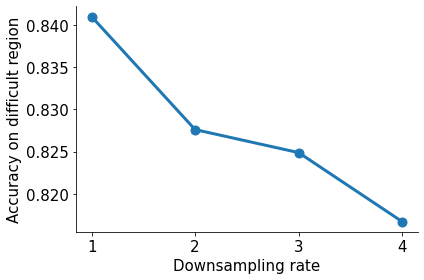

In [15]:
# plt.figure(dpi=300)
plt.plot(DOWNSAMPLE_list, accs, '.-', lw=3, ms=18)
plt.xticks(np.arange(1, len(accs) + 1))
plt.xlabel('Downsampling rate')
plt.ylabel('Accuracy on difficult region')
viz.savefig('downsampling')
plt.show()